# Inference with pretrained Nucleotide Transformer models

[![Open All Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/instadeepai/nucleotide-transformer/blob/main/examples/inference.ipynb)

## Installation and imports

In [1]:
import os

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import seaborn as sns 
import matplotlib.pyplot as plt
from src.models.pretrained import get_pretrained_model

## Download the weights
The following cell allows you to download the weights of any of the four nucleotide transformer model. It returns the weights dictionary, the haiku forward function, the tokenizer and the config dictionary.

Please also specify:
1. the layers at which you'd like to collect embeddings (e.g. (5, 10, 20) to get embeddings at layers 5, 10 and 20)
2. the attention maps you´d like to collect (e.g. ((1,4), (7,18)) to get attention maps corresponding to layer 1 head number 4 and layer 7 head number 18). Please refer to the config to see the number of layers and heads in the model.
3. the maximum number of tokens in the sequences you'll compute the inference on. You can put values up to value specified in the model's config (counting the class token that will be added automatically at the beginning of the sequence), however we recommend keeping this number as small as possible for optimized memory and inference time.

In [3]:
#@title Select a model
#@markdown ---
model_name = '500M_human_ref'#@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species']
#@markdown ---

In [4]:
# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    mixed_precision=False,
    embeddings_layers_to_save=(20,),
    attention_maps_to_save=((1, 4), (7, 18)),
    max_positions=32,
)
forward_fn = hk.transform(forward_fn)

/home/wadh6511/.cache/nucleotide_transformer/500M_human_ref/hyperparams.json: 100%|██████████| 815/815 [00:00<00:00, 21.6kB/s]
/home/wadh6511/.cache/nucleotide_transformer/500M_human_ref/ckpt.joblib: 100%|██████████| 1.94G/1.94G [00:17<00:00, 112MB/s] 


### Experimenting with model 

In [11]:
import inspect
inspect.getargspec(forward_fn.apply)

/tmp/ipykernel_122148/1254229426.py:2: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  inspect.getargspec(forward_fn.apply)


ArgSpec(args=['params'], varargs='args', keywords='kwargs', defaults=None)

## Define your input data and tokenize it
You can have a look at the tokens_str variable to see how your sequences have been split into tokens. The sequences will all be padded to the value you filled for max_positions.

In [44]:
import numpy as np

In [63]:
sequences = [''.join(i) for i in np.random.choice(np.array(['A', 'T', 'C', 'G']), (1000, 30))]

In [64]:

# Get data and tokenize it
# sequences = [
#     "ATTCCGAAATCGCTGACCGATCGTACGAAA",
#     "ATTTCTCTCTCTCTCTGAGATCGATCGATCGATATCTCTCGAGCTAGC",
# ]
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

## Do the Inference
The first time you query this cell will be slower than usual inference because of the computation graph compilation.

In [65]:
%%time
# Initialize random key
random_key = jax.random.PRNGKey(0)

# Infer
outs = forward_fn.apply(parameters, random_key, tokens)

CPU times: user 3.26 s, sys: 212 ms, total: 3.47 s
Wall time: 7.07 s


In [66]:
print(outs.keys())

dict_keys(['attention_map_layer_1_number_4', 'attention_map_layer_7_number_18', 'embeddings_20', 'logits'])


### Visualisation

In [67]:
# import graphviz
# dot = hk.experimental.to_dot(forward_fn.apply)(parameters, random_key, tokens)
# graphviz.Source(dot)

## Retrieve embeddings
And use them as you please! Enjoy!

In [68]:
print(outs["embeddings_20"].shape)

(1000, 32, 1280)


In [69]:
list(outs.keys())

['attention_map_layer_1_number_4',
 'attention_map_layer_7_number_18',
 'embeddings_20',
 'logits']

In [70]:
from sklearn.manifold import TSNE

In [71]:
X = outs["embeddings_20"]
X.shape

(1000, 32, 1280)

In [72]:
X = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))

In [73]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=1).fit_transform(X)

In [ ]:
X_embedded.shape

(3200, 2)

In [ ]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], alpha=0.1)

<Axes: >

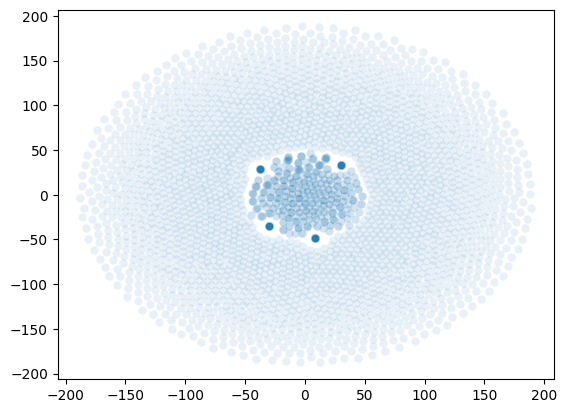

In [ ]:
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], alpha=0.1)

**Additional Tip**: Don't forget to remove the cls token and padded positions if you want for instance to compute mean embeddings!

In [ ]:
embeddings = outs["embeddings_20"][:, 1:, :]  # removing CLS token
padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
sequences_lengths = jnp.sum(padding_mask, axis=1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths

In [ ]:
print(mean_embeddings.shape)

## Get attention maps
Here is an example on how to retrieve attention maps at a specific layer for a given head and how to plot them.

In [ ]:
print(outs["attention_map_layer_1_number_4"].shape)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot attention maps
fig, axes = plt.subplots(nrows=1, ncols=2)

seq_length0, seq_length1 = int(sequences_lengths[0]), int(sequences_lengths[1])

# plot for first seq in the batch
im0 = axes[0].imshow(
    outs["attention_map_layer_1_number_4"][
        0, 1 : (seq_length0 + 1), 1 : (seq_length0 + 1)
    ]
)
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
tokens0 = tokens_str[0][1 : (seq_length0 + 1)]
axes[0].set_xticks(list(range(seq_length0)), tokens0, rotation=45)
axes[0].set_yticks(list(range(seq_length0)), tokens0, rotation=45)
fig.colorbar(im0, cax=cax0, orientation="vertical")

# plot for second seq in the batch
im1 = axes[1].imshow(
    outs["attention_map_layer_1_number_4"][
        1, 1 : (seq_length1 + 1), 1 : (seq_length1 + 1)
    ]
)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
tokens1 = tokens_str[1][1 : (seq_length1 + 1)]
axes[1].set_xticks(list(range(seq_length1)), tokens1, rotation=45)
axes[1].set_yticks(list(range(seq_length1)), tokens1, rotation=45)
fig.colorbar(im1, cax=cax1, orientation="vertical")

fig.tight_layout()

## Get probabilities
Finally, let's look at the model probabilities over the vocabulary at each position. These can be used notably to compute reconstruction accuracies and perplexities.

In [ ]:
logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    print(probas.shape)
    probabilities.append(probas)

Let's look in particular at a given sequence and position and show the top-k probabilities and corresponding tokens.

In [ ]:
sequence_id = 0
position_id = 1

probs = probabilities[sequence_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 5
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")